# **Homework 3 - Convolutional Neural Network**

This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.


There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. (2 pts)

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. (2 pts)

**Hard**: Utilize provided unlabeled data to obtain better results. (2 pts)

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr  3 14:52:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 25%   30C    P8     2W / 250W |     67MiB / 11018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


## **About the Dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.
Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [ ]:
"""
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip
"""

'\n# Download the dataset\n# You may choose where to download the data.\n\n# Google Drive\n!gdown --id \'1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy\' --output food-11.zip\n\n# Dropbox\n# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip\n\n# MEGA\n# !sudo apt install megatools\n# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"\n\n# Unzip the dataset.\n# This may take some time.\n!unzip -q food-11.zip\n'

## **Import Packages**

1.   [清單項目](https://)
2.   清單項目



First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
#from tqdm.auto import tqdm #may have some bug
from tqdm import tqdm



## **Change Dir to google drive**

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/hw3_data') #切換該目錄
os.listdir() #確認目錄內容
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/Colab Notebooks/hw3_data') #切換該目錄\nos.listdir() #確認目錄內容\n"

## **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_tfm2 = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # ToTensor() should be the last one of the transforms.
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_tfm3 = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # ToTensor() should be the last one of the transforms.
    transforms.RandomRotation((30,180)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_tfm4 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomPerspective(p=1.0),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_tfm5 = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_tfm6 = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=(0, 5), contrast=(
    0, 5), saturation=(0, 5), hue=(-0.1, 0.1)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set1 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
train_set2 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm2)
train_set3 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm3)
train_set4 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm4)
train_set5 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm5)
train_set6 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm6)


train_set = ConcatDataset([train_set1, train_set2, train_set3, train_set4, train_set5, train_set6])
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
#unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)

unlabeled_set1 = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
unlabeled_set2 = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm2)
unlabeled_set3 = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm3)
unlabeled_set4 = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm4)
unlabeled_set5 = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm5)
unlabeled_set6 = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm6)
unlabeled_set = ConcatDataset([unlabeled_set1, unlabeled_set2, unlabeled_set3, unlabeled_set4, unlabeled_set5, unlabeled_set6])


test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
# pin_memory = false, data will be swapped to driver if necessary
# default num_workers = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # out_channels = feature filter num, by adding 3 RGB input channel result within 1 filter
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # after 2x2 kernel maxpool, result will be intput witdth/2 * height/2
        
        # input image size: [3, 128, 128]
        """" original 
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 11)
        )
        """
        # add 2 Conv layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.6),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 11)
        )        

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [ ]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]

def get_pseudo_labels(dataset, model, threshold=0.9):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    # from https://github.com/1am9trash/Hung_Yi_Lee_ML_2021/blob/main/hw/hw3/hw3_code.ipynb 
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    # Iterate over the dataset by batches.
    for i, batch in enumerate(data_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))

    model.train()
    print ("\nNew pseudo label data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
#model = Classifier().to(device)

"""
#resnet18
model = torchvision.models.resnet18(pretrained=False).to(device)
model_weight_path = "./resnet18_pre.pth"
model.load_state_dict(torch.load(model_weight_path), strict=False)
"""

#resnet34
model = torchvision.models.resnet34(pretrained=False).to(device)
model_weight_path = "./resnet34_pre.pth"
model.load_state_dict(torch.load(model_weight_path), strict=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11).to(device)
model.device = device
# fix para in model layers
#for param in model.parameters():
#    param.requires_grad = True

model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 80

# Whether to do semi-supervised learning.
do_semi = True
best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []


for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi and best_acc > 0.75:
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set = get_pseudo_labels(unlabeled_set, model)

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        # 避免梯度爆炸or消失，將梯度限制在某個範圍
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
      best_acc = valid_acc
      torch.save(model.state_dict(), './model.ckpt')
      print('saving model with acc {:.5f}'.format(best_acc))

    #record for visualization
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)    

100%|██████████| 145/145 [00:31<00:00,  4.54it/s]


[ Train | 001/080 ] loss = 0.74860, acc = 0.75645


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


[ Valid | 001/080 ] loss = 0.91723, acc = 0.72083
saving model with acc 0.72083


100%|██████████| 145/145 [00:31<00:00,  4.61it/s]


[ Train | 002/080 ] loss = 0.37162, acc = 0.87917


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


[ Valid | 002/080 ] loss = 1.02757, acc = 0.72214
saving model with acc 0.72214


100%|██████████| 145/145 [00:31<00:00,  4.63it/s]


[ Train | 003/080 ] loss = 0.29851, acc = 0.90368


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


[ Valid | 003/080 ] loss = 0.81709, acc = 0.78307
saving model with acc 0.78307

New pseudo label data: 23071



100%|██████████| 324/324 [01:07<00:00,  4.78it/s]


[ Train | 004/080 ] loss = 0.30842, acc = 0.89962


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


[ Valid | 004/080 ] loss = 0.76272, acc = 0.78984
saving model with acc 0.78984

New pseudo label data: 25771



100%|██████████| 345/345 [01:12<00:00,  4.76it/s]


[ Train | 005/080 ] loss = 0.24166, acc = 0.92135


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


[ Valid | 005/080 ] loss = 0.63025, acc = 0.81875
saving model with acc 0.81875

New pseudo label data: 27354



100%|██████████| 358/358 [01:15<00:00,  4.75it/s]


[ Train | 006/080 ] loss = 0.20486, acc = 0.93357


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


[ Valid | 006/080 ] loss = 0.66112, acc = 0.82526
saving model with acc 0.82526

New pseudo label data: 28883



100%|██████████| 370/370 [01:17<00:00,  4.77it/s]


[ Train | 007/080 ] loss = 0.19839, acc = 0.93516


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


[ Valid | 007/080 ] loss = 0.71456, acc = 0.82240

New pseudo label data: 29213



100%|██████████| 372/372 [01:17<00:00,  4.77it/s]


[ Train | 008/080 ] loss = 0.18694, acc = 0.93891


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


[ Valid | 008/080 ] loss = 0.85227, acc = 0.78438

New pseudo label data: 28515



100%|██████████| 367/367 [01:17<00:00,  4.76it/s]


[ Train | 009/080 ] loss = 0.18151, acc = 0.94110


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


[ Valid | 009/080 ] loss = 0.85077, acc = 0.79427

New pseudo label data: 30050



100%|██████████| 379/379 [01:19<00:00,  4.75it/s]


[ Train | 010/080 ] loss = 0.17787, acc = 0.94362


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


[ Valid | 010/080 ] loss = 0.73334, acc = 0.82917
saving model with acc 0.82917

New pseudo label data: 30787



100%|██████████| 384/384 [01:20<00:00,  4.76it/s]


[ Train | 011/080 ] loss = 0.16755, acc = 0.94627


100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


[ Valid | 011/080 ] loss = 0.78880, acc = 0.79557

New pseudo label data: 31021



100%|██████████| 386/386 [01:20<00:00,  4.81it/s]


[ Train | 012/080 ] loss = 0.16023, acc = 0.94825


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


[ Valid | 012/080 ] loss = 0.97625, acc = 0.80182

New pseudo label data: 31112



100%|██████████| 387/387 [01:21<00:00,  4.74it/s]


[ Train | 013/080 ] loss = 0.16983, acc = 0.94527


100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


[ Valid | 013/080 ] loss = 0.74577, acc = 0.82188

New pseudo label data: 31345



100%|██████████| 389/389 [01:21<00:00,  4.77it/s]


[ Train | 014/080 ] loss = 0.14423, acc = 0.95451


100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


[ Valid | 014/080 ] loss = 0.77646, acc = 0.82214

New pseudo label data: 32234



100%|██████████| 396/396 [01:22<00:00,  4.78it/s]


[ Train | 015/080 ] loss = 0.15136, acc = 0.95202


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


[ Valid | 015/080 ] loss = 0.78603, acc = 0.80313

New pseudo label data: 31944



100%|██████████| 393/393 [01:22<00:00,  4.74it/s]


[ Train | 016/080 ] loss = 0.13631, acc = 0.95684


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


[ Valid | 016/080 ] loss = 0.89097, acc = 0.80469

New pseudo label data: 32381



100%|██████████| 397/397 [01:23<00:00,  4.77it/s]


[ Train | 017/080 ] loss = 0.14076, acc = 0.95417


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


[ Valid | 017/080 ] loss = 0.71246, acc = 0.83646
saving model with acc 0.83646

New pseudo label data: 32949



100%|██████████| 401/401 [01:23<00:00,  4.79it/s]


[ Train | 018/080 ] loss = 0.13722, acc = 0.95581


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


[ Valid | 018/080 ] loss = 0.78409, acc = 0.81302

New pseudo label data: 32856



100%|██████████| 401/401 [01:23<00:00,  4.79it/s]


[ Train | 019/080 ] loss = 0.13194, acc = 0.95870


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


[ Valid | 019/080 ] loss = 0.89645, acc = 0.80260

New pseudo label data: 32926



100%|██████████| 401/401 [01:24<00:00,  4.76it/s]


[ Train | 020/080 ] loss = 0.13303, acc = 0.95872


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


[ Valid | 020/080 ] loss = 0.80507, acc = 0.81484

New pseudo label data: 33834



100%|██████████| 408/408 [01:25<00:00,  4.77it/s]


[ Train | 021/080 ] loss = 0.13719, acc = 0.95749


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


[ Valid | 021/080 ] loss = 0.79904, acc = 0.80469

New pseudo label data: 33676



100%|██████████| 407/407 [01:25<00:00,  4.78it/s]


[ Train | 022/080 ] loss = 0.11686, acc = 0.96345


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


[ Valid | 022/080 ] loss = 1.05055, acc = 0.75938

New pseudo label data: 33146



100%|██████████| 403/403 [01:24<00:00,  4.77it/s]


[ Train | 023/080 ] loss = 0.13817, acc = 0.95613


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


[ Valid | 023/080 ] loss = 0.93682, acc = 0.80495

New pseudo label data: 33530



100%|██████████| 406/406 [01:24<00:00,  4.78it/s]


[ Train | 024/080 ] loss = 0.12326, acc = 0.96100


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


[ Valid | 024/080 ] loss = 0.79459, acc = 0.81510

New pseudo label data: 33964



100%|██████████| 409/409 [01:25<00:00,  4.79it/s]


[ Train | 025/080 ] loss = 0.11785, acc = 0.96271


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


[ Valid | 025/080 ] loss = 0.92439, acc = 0.81693

New pseudo label data: 34305



100%|██████████| 412/412 [01:25<00:00,  4.80it/s]


[ Train | 026/080 ] loss = 0.12024, acc = 0.96226


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


[ Valid | 026/080 ] loss = 0.78851, acc = 0.80651

New pseudo label data: 34315



100%|██████████| 412/412 [01:26<00:00,  4.79it/s]


[ Train | 027/080 ] loss = 0.11233, acc = 0.96448


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


[ Valid | 027/080 ] loss = 0.91533, acc = 0.80156

New pseudo label data: 34502



100%|██████████| 413/413 [01:25<00:00,  4.81it/s]


[ Train | 028/080 ] loss = 0.11597, acc = 0.96383


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


[ Valid | 028/080 ] loss = 0.80164, acc = 0.79740

New pseudo label data: 34540



100%|██████████| 414/414 [01:26<00:00,  4.80it/s]


[ Train | 029/080 ] loss = 0.11056, acc = 0.96601


100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


[ Valid | 029/080 ] loss = 0.78405, acc = 0.82995

New pseudo label data: 34575



100%|██████████| 414/414 [01:26<00:00,  4.79it/s]


[ Train | 030/080 ] loss = 0.10661, acc = 0.96698


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


[ Valid | 030/080 ] loss = 0.95877, acc = 0.78646

New pseudo label data: 33370



100%|██████████| 405/405 [01:24<00:00,  4.80it/s]


[ Train | 031/080 ] loss = 0.11256, acc = 0.96478


100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


[ Valid | 031/080 ] loss = 0.86511, acc = 0.81771

New pseudo label data: 34056



100%|██████████| 410/410 [01:25<00:00,  4.78it/s]


[ Train | 032/080 ] loss = 0.10496, acc = 0.96850


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


[ Valid | 032/080 ] loss = 0.75011, acc = 0.83750
saving model with acc 0.83750

New pseudo label data: 34972



100%|██████████| 417/417 [01:27<00:00,  4.77it/s]


[ Train | 033/080 ] loss = 0.10543, acc = 0.96699


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


[ Valid | 033/080 ] loss = 0.93791, acc = 0.80937

New pseudo label data: 35416



100%|██████████| 421/421 [01:28<00:00,  4.76it/s]


[ Train | 034/080 ] loss = 0.10600, acc = 0.96669


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


[ Valid | 034/080 ] loss = 0.83631, acc = 0.79505

New pseudo label data: 35366



100%|██████████| 420/420 [01:27<00:00,  4.79it/s]


[ Train | 035/080 ] loss = 0.10788, acc = 0.96628


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


[ Valid | 035/080 ] loss = 0.73337, acc = 0.82266

New pseudo label data: 35442



100%|██████████| 421/421 [01:27<00:00,  4.81it/s]


[ Train | 036/080 ] loss = 0.10158, acc = 0.96806


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


[ Valid | 036/080 ] loss = 0.73279, acc = 0.82969

New pseudo label data: 35283



100%|██████████| 420/420 [01:27<00:00,  4.78it/s]


[ Train | 037/080 ] loss = 0.09977, acc = 0.96869


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


[ Valid | 037/080 ] loss = 0.80761, acc = 0.80469

New pseudo label data: 35672



100%|██████████| 423/423 [01:28<00:00,  4.78it/s]


[ Train | 038/080 ] loss = 0.09396, acc = 0.97121


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


[ Valid | 038/080 ] loss = 0.81908, acc = 0.82917

New pseudo label data: 36034



100%|██████████| 425/425 [01:28<00:00,  4.79it/s]


[ Train | 039/080 ] loss = 0.10231, acc = 0.96800


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


[ Valid | 039/080 ] loss = 0.84299, acc = 0.81328

New pseudo label data: 35311



100%|██████████| 420/420 [01:27<00:00,  4.80it/s]


[ Train | 040/080 ] loss = 0.09258, acc = 0.97080


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


[ Valid | 040/080 ] loss = 0.92696, acc = 0.78854

New pseudo label data: 35614



100%|██████████| 422/422 [01:28<00:00,  4.77it/s]


[ Train | 041/080 ] loss = 0.10012, acc = 0.96949


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


[ Valid | 041/080 ] loss = 0.88630, acc = 0.79635

New pseudo label data: 35784



100%|██████████| 423/423 [01:27<00:00,  4.82it/s]


[ Train | 042/080 ] loss = 0.09389, acc = 0.97089


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


[ Valid | 042/080 ] loss = 0.86287, acc = 0.81042

New pseudo label data: 35714



100%|██████████| 423/423 [01:28<00:00,  4.81it/s]


[ Train | 043/080 ] loss = 0.09087, acc = 0.97213


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


[ Valid | 043/080 ] loss = 1.13737, acc = 0.78854

New pseudo label data: 35722



100%|██████████| 423/423 [01:28<00:00,  4.79it/s]


[ Train | 044/080 ] loss = 0.08404, acc = 0.97379


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


[ Valid | 044/080 ] loss = 0.79278, acc = 0.82448

New pseudo label data: 35840



100%|██████████| 424/424 [01:28<00:00,  4.82it/s]


[ Train | 045/080 ] loss = 0.09560, acc = 0.96989


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


[ Valid | 045/080 ] loss = 0.86439, acc = 0.82786

New pseudo label data: 36425



100%|██████████| 428/428 [01:28<00:00,  4.82it/s]


[ Train | 046/080 ] loss = 0.09327, acc = 0.97058


100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


[ Valid | 046/080 ] loss = 0.87620, acc = 0.80208

New pseudo label data: 35920



100%|██████████| 425/425 [01:28<00:00,  4.83it/s]


[ Train | 047/080 ] loss = 0.08240, acc = 0.97392


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


[ Valid | 047/080 ] loss = 0.79983, acc = 0.82344

New pseudo label data: 36117



100%|██████████| 426/426 [01:28<00:00,  4.82it/s]


[ Train | 048/080 ] loss = 0.08877, acc = 0.97236


100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


[ Valid | 048/080 ] loss = 0.80736, acc = 0.83568

New pseudo label data: 36148



100%|██████████| 426/426 [01:29<00:00,  4.76it/s]


[ Train | 049/080 ] loss = 0.08890, acc = 0.97308


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


[ Valid | 049/080 ] loss = 0.82316, acc = 0.82474

New pseudo label data: 36482



100%|██████████| 429/429 [01:28<00:00,  4.83it/s]


[ Train | 050/080 ] loss = 0.08898, acc = 0.97279


100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


[ Valid | 050/080 ] loss = 0.80286, acc = 0.81484

New pseudo label data: 36074



100%|██████████| 426/426 [01:28<00:00,  4.84it/s]


[ Train | 051/080 ] loss = 0.08365, acc = 0.97456


100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


[ Valid | 051/080 ] loss = 1.04498, acc = 0.78906

New pseudo label data: 36564



100%|██████████| 430/430 [01:29<00:00,  4.83it/s]


[ Train | 052/080 ] loss = 0.08751, acc = 0.97327


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


[ Valid | 052/080 ] loss = 0.82043, acc = 0.82161

New pseudo label data: 36647



100%|██████████| 430/430 [01:28<00:00,  4.86it/s]


[ Train | 053/080 ] loss = 0.08684, acc = 0.97400


100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


[ Valid | 053/080 ] loss = 0.90519, acc = 0.81094

New pseudo label data: 36469



100%|██████████| 429/429 [01:29<00:00,  4.81it/s]


[ Train | 054/080 ] loss = 0.08877, acc = 0.97409


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


[ Valid | 054/080 ] loss = 0.85139, acc = 0.83099

New pseudo label data: 36870



100%|██████████| 432/432 [01:30<00:00,  4.80it/s]


[ Train | 055/080 ] loss = 0.08114, acc = 0.97503


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


[ Valid | 055/080 ] loss = 0.95027, acc = 0.80469

New pseudo label data: 36900



100%|██████████| 432/432 [01:29<00:00,  4.81it/s]


[ Train | 056/080 ] loss = 0.08458, acc = 0.97405


100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


[ Valid | 056/080 ] loss = 0.77819, acc = 0.82396

New pseudo label data: 36947



100%|██████████| 433/433 [01:30<00:00,  4.80it/s]


[ Train | 057/080 ] loss = 0.08347, acc = 0.97425


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


[ Valid | 057/080 ] loss = 0.71488, acc = 0.84844
saving model with acc 0.84844

New pseudo label data: 36890



100%|██████████| 432/432 [01:30<00:00,  4.78it/s]


[ Train | 058/080 ] loss = 0.07460, acc = 0.97721


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


[ Valid | 058/080 ] loss = 0.76817, acc = 0.82448

New pseudo label data: 37024



100%|██████████| 433/433 [01:31<00:00,  4.74it/s]


[ Train | 059/080 ] loss = 0.07930, acc = 0.97633


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


[ Valid | 059/080 ] loss = 0.85199, acc = 0.79896

New pseudo label data: 36754



100%|██████████| 431/431 [01:29<00:00,  4.81it/s]


[ Train | 060/080 ] loss = 0.08792, acc = 0.97393


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


[ Valid | 060/080 ] loss = 0.98981, acc = 0.78828

New pseudo label data: 36313



100%|██████████| 428/428 [01:29<00:00,  4.80it/s]


[ Train | 061/080 ] loss = 0.07767, acc = 0.97578


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


[ Valid | 061/080 ] loss = 0.96116, acc = 0.80208

New pseudo label data: 37264



100%|██████████| 435/435 [01:29<00:00,  4.83it/s]


[ Train | 062/080 ] loss = 0.07804, acc = 0.97529


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


[ Valid | 062/080 ] loss = 0.78952, acc = 0.84010

New pseudo label data: 37146



100%|██████████| 434/434 [01:30<00:00,  4.82it/s]


[ Train | 063/080 ] loss = 0.07494, acc = 0.97712


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


[ Valid | 063/080 ] loss = 0.85175, acc = 0.79583

New pseudo label data: 37188



100%|██████████| 434/434 [01:30<00:00,  4.80it/s]


[ Train | 064/080 ] loss = 0.07951, acc = 0.97618


100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


[ Valid | 064/080 ] loss = 0.71002, acc = 0.84714

New pseudo label data: 37211



100%|██████████| 435/435 [01:30<00:00,  4.80it/s]


[ Train | 065/080 ] loss = 0.07502, acc = 0.97719


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


[ Valid | 065/080 ] loss = 0.85149, acc = 0.81250

New pseudo label data: 37269



100%|██████████| 435/435 [01:30<00:00,  4.81it/s]


[ Train | 066/080 ] loss = 0.07301, acc = 0.97775


100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


[ Valid | 066/080 ] loss = 0.82208, acc = 0.82786

New pseudo label data: 37340



100%|██████████| 436/436 [01:30<00:00,  4.81it/s]


[ Train | 067/080 ] loss = 0.07751, acc = 0.97660


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


[ Valid | 067/080 ] loss = 0.83335, acc = 0.81224

New pseudo label data: 36629



100%|██████████| 430/430 [01:28<00:00,  4.84it/s]


[ Train | 068/080 ] loss = 0.07442, acc = 0.97829


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


[ Valid | 068/080 ] loss = 1.17942, acc = 0.79427

New pseudo label data: 36799



100%|██████████| 431/431 [01:29<00:00,  4.80it/s]


[ Train | 069/080 ] loss = 0.07471, acc = 0.97741


100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


[ Valid | 069/080 ] loss = 0.89561, acc = 0.81693

New pseudo label data: 37282



100%|██████████| 435/435 [01:30<00:00,  4.82it/s]


[ Train | 070/080 ] loss = 0.07154, acc = 0.97812


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


[ Valid | 070/080 ] loss = 0.78897, acc = 0.83021

New pseudo label data: 37413



100%|██████████| 436/436 [01:30<00:00,  4.82it/s]


[ Train | 071/080 ] loss = 0.07492, acc = 0.97724


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


[ Valid | 071/080 ] loss = 0.92734, acc = 0.78411

New pseudo label data: 37616



100%|██████████| 438/438 [01:31<00:00,  4.78it/s]


[ Train | 072/080 ] loss = 0.07375, acc = 0.97704


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


[ Valid | 072/080 ] loss = 0.87421, acc = 0.80521

New pseudo label data: 37663



100%|██████████| 438/438 [01:31<00:00,  4.78it/s]


[ Train | 073/080 ] loss = 0.07235, acc = 0.97819


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


[ Valid | 073/080 ] loss = 0.96333, acc = 0.78594

New pseudo label data: 37631



100%|██████████| 438/438 [01:30<00:00,  4.83it/s]


[ Train | 074/080 ] loss = 0.07780, acc = 0.97585


100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


[ Valid | 074/080 ] loss = 0.77784, acc = 0.85234
saving model with acc 0.85234

New pseudo label data: 37678



100%|██████████| 438/438 [01:31<00:00,  4.81it/s]


[ Train | 075/080 ] loss = 0.06903, acc = 0.97890


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


[ Valid | 075/080 ] loss = 0.97556, acc = 0.80443

New pseudo label data: 37598



100%|██████████| 438/438 [01:31<00:00,  4.80it/s]


[ Train | 076/080 ] loss = 0.07181, acc = 0.97792


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


[ Valid | 076/080 ] loss = 0.76945, acc = 0.83333

New pseudo label data: 37258



100%|██████████| 435/435 [01:30<00:00,  4.80it/s]


[ Train | 077/080 ] loss = 0.07207, acc = 0.97838


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


[ Valid | 077/080 ] loss = 0.92829, acc = 0.80339

New pseudo label data: 37412



100%|██████████| 436/436 [01:30<00:00,  4.83it/s]


[ Train | 078/080 ] loss = 0.06842, acc = 0.97954


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


[ Valid | 078/080 ] loss = 0.89315, acc = 0.81484

New pseudo label data: 37676



100%|██████████| 438/438 [01:31<00:00,  4.80it/s]


[ Train | 079/080 ] loss = 0.07203, acc = 0.97810


100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


[ Valid | 079/080 ] loss = 1.01968, acc = 0.80339

New pseudo label data: 37474



100%|██████████| 437/437 [01:31<00:00,  4.79it/s]


[ Train | 080/080 ] loss = 0.06912, acc = 0.97901


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

[ Valid | 080/080 ] loss = 1.02041, acc = 0.78516


## **Testing**

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

### **WARNING -- Keep in Mind**

Cheating includes but not limited to:
1.   using testing labels,
2.   submitting results to previous Kaggle competitions,
3.   sharing predictions with others,
4.   copying codes from any creatures on Earth,
5.   asking other people to do it for you.

Any violations bring you punishments from getting a discount on the final grade to failing the course.

It is your responsibility to check whether your code violates the rules.
When citing codes from the Internet, you should know what these codes exactly do.
You will **NOT** be tolerated if you break the rule and claim you don't know what these codes do.


In [ ]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
""" turn off when using resnet
del model
model = Classifier().to(device)
model.load_state_dict(torch.load('./model.ckpt'))
"""
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

100%|██████████| 27/27 [00:16<00:00,  1.64it/s]


In [ ]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

## **Visualize Result**



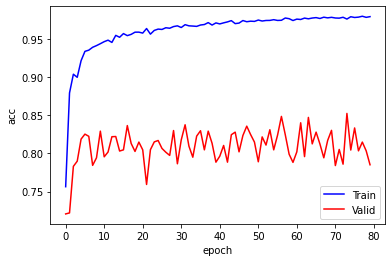

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_record))
train = torch.tensor(train_acc_record, device='cpu')
valid = torch.tensor(valid_acc_record, device='cpu')

plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(x, train, color="blue", label="Train")
plt.plot(x, valid, color="red", label="Valid")
plt.legend(loc="best")
plt.show()

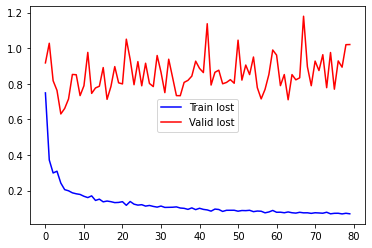

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_record))
train = torch.tensor(train_loss_record, device='cpu')
valid = torch.tensor(valid_loss_record, device='cpu')

plt.plot(x, train_loss_record, color="blue", label="Train lost")
plt.plot(x, valid_loss_record, color="red", label="Valid lost")
plt.legend(loc="best") 
plt.show()